# Quantitative evaluation of "template fit landmarking"

(Can anyone think of a better name?)

This notebook uses the template mesh fitting code in iris package to extract landmarks from the in3d-tg3d corresponding scans dataset. Selected fitted landmarks are compared to the original landmarks provided by tg3d or in3d (index-based algorithm). 

**Background**

The adverse effect of poor landmark consistency was noticed in experiment 07-in3d-crotch. We found that in3d and tg3d crotch landmarks are very differently defined, which affect how the measurements are extracted from the body. Additionally, new mobile scanning solutions we want to try might not even give us any landmarks in the first place. These motivate us to come up with our own landmarking solution, which will be consistent across scanning sources.

The approach we chose for this experiment is to use STAR: a pre-trained shape space of human meshes with consistent topology. We can use this to help us fitting a template human mesh onto a target scan mesh, then landmarks can be extracted simply by choosing the vertex indices on the template which correspond to the parts we want. 

The code that does this is implemented in `iris` package on `iris-project` repo, and used in this notebook to perform quantitative evaluation.

**Results**

- There is no big difference in errors between genders
- There is a BIG difference in errors among tg3d scans and in3d scans. This indicates that a big interfering variable is the difference between tg3d and in3d landmarks in the first place.

I think this quantitative evaluation is not very revealing, and we might as well consider this new landmarking method as its own thing, as long as the qualitative results (inspecting the visualization of landmarks on bodies) make sense.

**Dataset**

Uses the in3d-tg3d corresponding scans dataset on wandb at artifact `hellounspun/in3d-crotch/in3d-tg3d-scans:v1`

In [1]:
import trimesh
from pathlib import Path
import vedo
from tqdm import tqdm
import wandb
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from iris.anthropometry.template_fit.template_fit import fit_template
from iris.anthropometry.template_fit.landmarking import _project_landmarks

In [2]:
tqdm.pandas()
%config InlineBackend.figure_format='retina'

In [3]:
run = wandb.init(project='experiments-star-template-fit-landmarking', job_type='quantitative-eval')
data_dir = Path(run.use_artifact('in3d-crotch/in3d-tg3d-scans:v1').download())
scans_df = pd.read_pickle(data_dir/'df.pkl')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hellounspun (use `wandb login --relogin` to force relogin)


wandb: Downloading large artifact in3d-tg3d-scans:v1, 290.36MB. 50 files... Done. 0:0:0


In [4]:
def template_fit_landmark(mesh, **kwargs):
    lm = _project_landmarks(mesh, fit_template(mesh, **kwargs))
    del lm['crotch_like_tg3d']
    return lm
def tmesh(mesh, c='grey', alpha=0.5):
    return vedo.Mesh(mesh, c=c, alpha=alpha) 

In [5]:
scans_df.head()

person_index  gender                             scan_uuid source  \
0             0       2  26ee8e44-1ab6-4505-8bb7-ffe132154d93   tg3d   
1             0       2  dfd80a3f-c96d-43b0-833c-dedbcd84f9ca   in3d   
2             1       2  aa7eee46-bcf8-4c58-8995-4dffa97d939d   tg3d   
3             1       2  48604db9-36f2-4558-a503-4b02f9fdaf7f   in3d   
4             2       1  74556087-4e1c-42a2-aa38-15b0066409f0   tg3d   

                                       mesh_path  \
0  tg3d/26ee8e44-1ab6-4505-8bb7-ffe132154d93.obj   
1  in3d/dfd80a3f-c96d-43b0-833c-dedbcd84f9ca.obj   
2  tg3d/aa7eee46-bcf8-4c58-8995-4dffa97d939d.obj   
3  in3d/48604db9-36f2-4558-a503-4b02f9fdaf7f.obj   
4  tg3d/74556087-4e1c-42a2-aa38-15b0066409f0.obj   

                                          scan_entry  \
0  {'created': 1616104039, 'externalId': '7ed53db...   
1  {'created': 1616104207, 'externalId': '25ad04c...   
2  {'created': 1614158934, 'externalId': '11d391d...   
3  {'created': 1614903159, 'externalId': '0000000...   
4  {'created': 1614911743, 'externalId': 'a5e82ad...   

                                           landmarks  \
0  {'curve': {'neck': [[  -9.293997  -32.38681  1...   
1  {'curve': {}, 'joint': {'l_hip': [-14.124025, ...   
2  {'curve': {'neck': [[ -13.682252  -51.566784 1...   
3  {'curve': {}, 'joint': {'l_hip': [-21.346243, ...   
4  {'curve': {'neck': [[ -51.473053  -45.930527 1...   

                                        measurements  
0  {'shapes': {'upper_waist': [[-1.29255135e-01 -...  
1  {'shapes': {'upper_waist': [[  -7.68436346 -12...  
2  {'shapes': {'upper_waist': [[  39.37608293 -12...  
3  {'shapes': {'upper_waist': [[  14.0033578  -11...  
4  {'shapes': {'upper_waist': [[ -13.06774145 -14...

In [6]:
# perform template fit landmarking 
lms = []
for i, row in tqdm(scans_df.iterrows(), total=scans_df.shape[0]):
    target_mesh = trimesh.load_mesh(data_dir/row['mesh_path'])
    fitted_lm = template_fit_landmark(target_mesh)
    lms.append(fitted_lm)
scans_df['fitted_lm'] = lms

100%|██████████| 48/48 [05:11<00:00,  6.49s/it]


## Example scan and its landmarks

<span style="color: red"><b>red = fitted landmarks</b></span><br/>
<span style="color: blue"><b>blue = original "surface" landmarks</b></span><br/>
<span style="color: yellow"><b>yellow = original "joint" landmarks</b></span>

In [7]:
row = scans_df.iloc[0]
target_mesh = trimesh.load_mesh(data_dir/row['mesh_path'])

vp = vedo.Plotter()
vp.show(
    tmesh(target_mesh), 
    vedo.Spheres(list(row['fitted_lm'].values()), r=10, c='red'), 
    vedo.Spheres(list(row['landmarks']['surface'].values()), r=10, c='blue'),
    vedo.Spheres(list(row['landmarks']['joint'].values()), r=10, c='yellow'),
    viewup='z'
)

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[842.8670958143666,…

## Landmark metrics to evaluate

- distance between crotch points
- distance between navel points
- difference of knee heights
- difference of ankle heights
- difference of underbust heights

In [9]:
def compare_landmarks(original_lm, fitted_lm):
    olm, flm = original_lm, fitted_lm
    crotch_dist = np.linalg.norm(olm['surface']['crotch_point']-flm['crotch'])
    navel_dist = np.linalg.norm(olm['surface']['navel']-flm['navel'])
    knee_height_diff = np.mean((flm['knee_left_front'][2], flm['knee_left_back'][2]))-olm['joint']['l_knee'][2]
    ankle_height_diff = np.mean((flm['ankle_left_out'][2], flm['ankle_left_in'][2]))-olm['joint']['l_ankle'][2]
    underbust_height_diff = flm['underbust_left'][2]-olm['surface']['underbust_left'][2]
    
    return dict(
        crotch_dist=crotch_dist, 
        navel_dist=navel_dist, 
        knee_height_diff=knee_height_diff, 
        ankle_height_diff=ankle_height_diff, 
        underbust_height_diff=underbust_height_diff
    )

metrics = pd.DataFrame([compare_landmarks(row['landmarks'], row['fitted_lm']) for i, row in scans_df.iterrows()], 
             index=scans_df.index)
abs_metrics = abs(metrics)
metrics[['person_index', 'gender', 'source']] = scans_df[['person_index', 'gender', 'source']].copy()
abs_metrics[['person_index', 'gender', 'source']] = scans_df[['person_index', 'gender', 'source']].copy()
metrics.head()

crotch_dist  navel_dist  knee_height_diff  ankle_height_diff  \
0    41.955927   10.928723        -19.289291         -20.017468   
1    45.542110    9.358514        -28.829285          -3.281922   
2    33.218710   25.386074        -16.933136          -4.645558   
3    46.842604   10.624321        -22.037109          -5.849304   
4    31.957005   25.160150        -12.782577         -14.209717   

   underbust_height_diff  person_index  gender source  
0             -58.988648             0       2   tg3d  
1               1.615845             0       2   in3d  
2             -60.600341             1       2   tg3d  
3              17.120483             1       2   in3d  
4             -59.882080             2       1   tg3d

### Overall error stats

In [10]:
overall_stats = abs_metrics.drop(['person_index', 'source', 'gender'], axis=1).describe()
overall_stats

crotch_dist  navel_dist  knee_height_diff  ankle_height_diff  \
count    48.000000   48.000000         48.000000          48.000000   
mean     46.437226   18.680225         18.342621           9.822377   
std      26.716280   14.018135         11.444561           4.988326   
min       1.785908    0.000000          1.437485           1.250035   
25%      26.505899    9.672416          8.486931           5.949295   
50%      47.068365   14.653927         15.684418           8.301895   
75%      67.046898   27.113323         28.612854          13.230086   
max     101.069662   54.161118         44.609283          20.742046   

       underbust_height_diff  
count              48.000000  
mean               42.095685  
std                30.689703  
min                 0.832276  
25%                20.029754  
50%                41.906250  
75%                60.061645  
max               108.072876

### Error means grouped by gender

In [11]:
abs_metrics.drop(['person_index', 'source'], axis=1).groupby('gender').mean().append(
    overall_stats.loc['mean'].rename('overall')
)

crotch_dist  navel_dist  knee_height_diff  ankle_height_diff  \
gender                                                                  
1          47.590304   17.708176         18.736514          10.386227   
2          45.074497   19.829011         17.877111           9.156009   
overall    46.437226   18.680225         18.342621           9.822377   

         underbust_height_diff  
gender                          
1                    47.798232  
2                    35.356312  
overall              42.095685

### Error means grouped by scan source

In [12]:
abs_metrics.drop(['person_index', 'gender'], axis=1).groupby('source').mean().append(
    overall_stats.loc['mean'].rename('overall')
)

crotch_dist  navel_dist  knee_height_diff  ankle_height_diff  \
source                                                                  
in3d       66.208706    9.116899         24.096058           7.654956   
tg3d       26.665746   28.243552         12.589184          11.989799   
overall    46.437226   18.680225         18.342621           9.822377   

         underbust_height_diff  
source                          
in3d                 16.735820  
tg3d                 67.455551  
overall              42.095685

### Errors distribution histogram plots

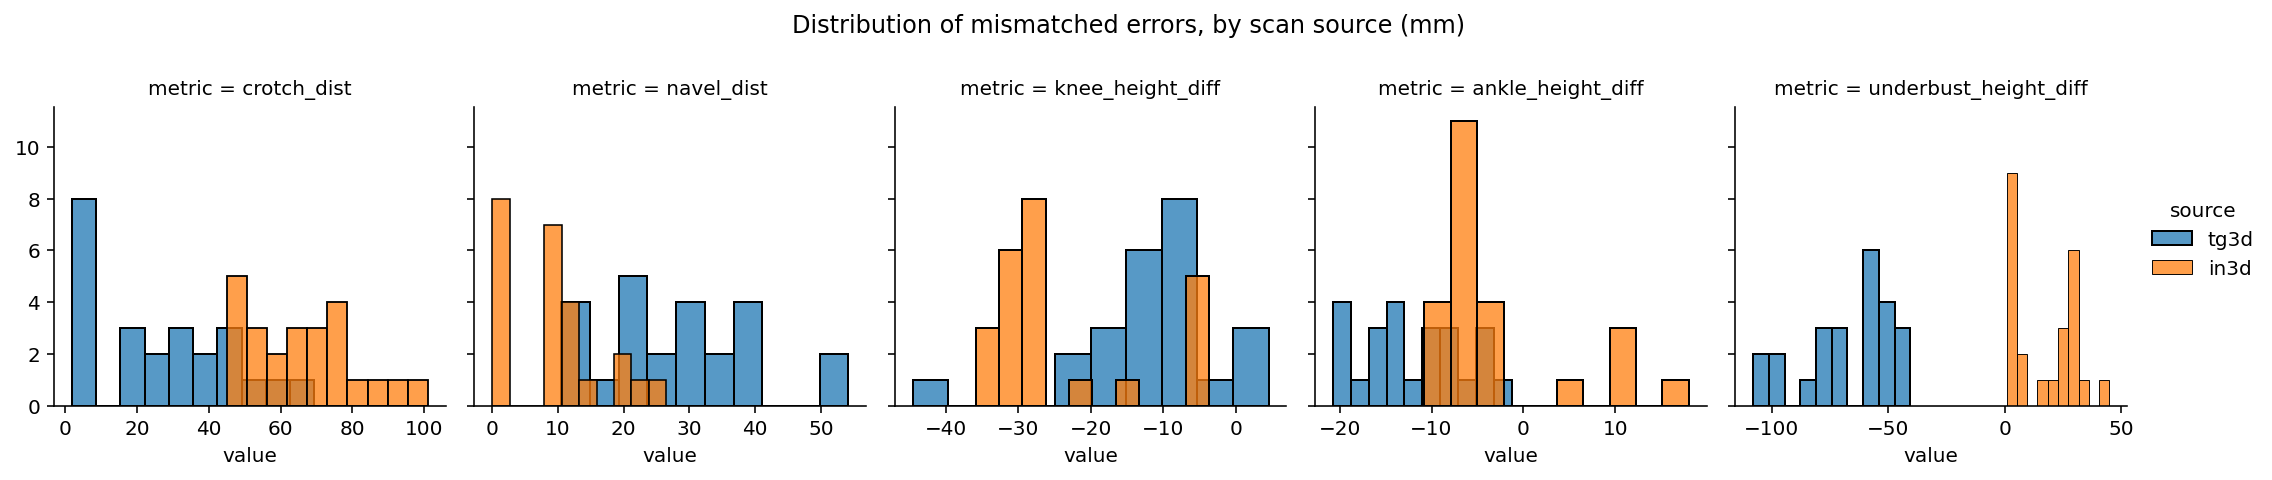

In [13]:
metrics_melted = metrics.melt(id_vars=['person_index', 'gender', 'source'], var_name='metric')
g = sns.FacetGrid(metrics_melted, col='metric', hue='source', sharex=False)
g.map(sns.histplot, 'value', bins=10).add_legend()
plt.suptitle('Distribution of mismatched errors, by scan source (mm)', y=1.1)
plt.show()

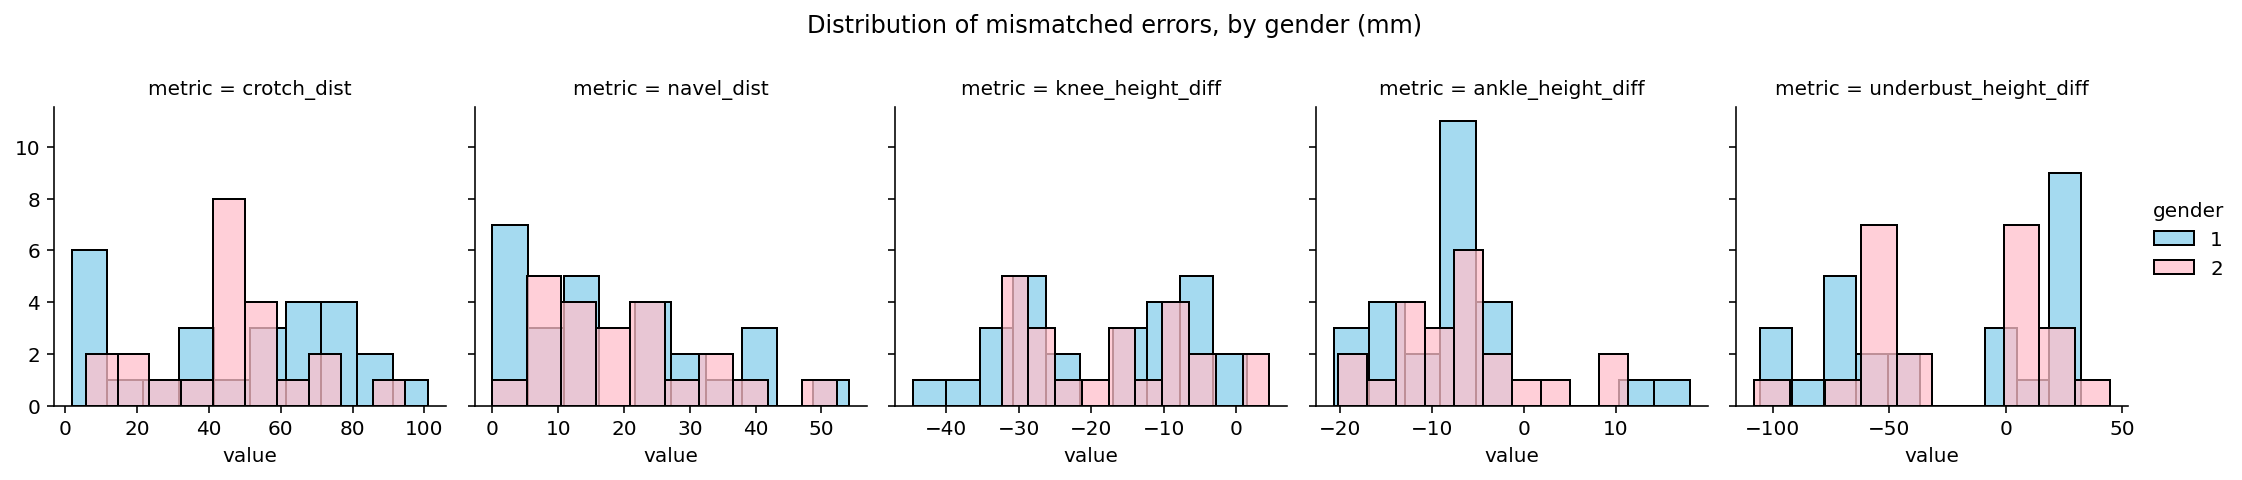

In [14]:
g2 = sns.FacetGrid(metrics_melted, col='metric', hue='gender', sharex=False, hue_kws={'color': ['skyblue', 'pink']})
g2.map(sns.histplot, 'value', bins=10).add_legend()
plt.suptitle('Distribution of mismatched errors, by gender (mm)', y=1.1)
plt.show()

### Discussions

- When grouped by gender, the errors are very similar across genders.
- When grouped by scan source, there's much clearer discrepency. Fitted landmarks have much closer nabel, ankle, and underbust to in3d than tg3d, and vice-versa for crotch and knee. This indicates that most of the errors come from disagreement between in3d, tg3d, and the fitted landmarks choice of where to define the landmarks. 

In [15]:
idx = metrics['crotch_dist'].argmax()
row = scans_df.iloc[idx]
target_mesh = trimesh.load_mesh(data_dir/row['mesh_path'])
vedo.show(
    tmesh(target_mesh),
    vedo.Spheres(list(row['fitted_lm'].values()), r=10), 
    vedo.Spheres(list(row['landmarks']['surface'].values()), r=10, c='blue'),
    vedo.Spheres(list(row['landmarks']['joint'].values()), r=10, c='yellow'),
    viewup='z'
)

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[1034.2891396332493…

Above is the scan with the worst crotch matching. Note how it is an in3d scan, and the original crotch is much further front than tg3d scans, as established before. This is what concerns me about quantitative evaluation, as we have to assume that one landmarking solution is correct, but that's not the case. Thus, even if the quantitative result for template fitted landmarks are not stellar, the main decider should still be the qualitative inspection.

## Conclusions

I think we should focus on the qualitative fitting results, available as a report on wandb [here](https://wandb.ai/hellounspun/experiments-star-template-fit-landmarking/reports/Snapshot-Jun-3-2021-11-21am--Vmlldzo3NTAyOTI), to tell us whether the landmarking is working or not. From my visual inspection, it is.

### Next steps

- There are still concerns about us having too many standards of landmarkings (fit3d, in3d, tg3d, this). I largely based most of the landmarks fitted with STAR on Browzwear's guide for VStitcher avatar landmarking: https://support.browzwear.com/VStitcher/Avatars/imp-avatar-setup.htm. Going forward, it will certainly be prudent to find a good standard to adhere to, e.g. ASTM or the new IEEE standard, to be more consistent.
- The navel landmark is the most inaccurate one. This is because on a scan mesh, it is often very easy to visually guess where the navel is based on the indentation on the stomach, but this detail seems to be too minute for the mesh fitting to pick up on. Thus, it might be both appropriate and possible to local the navel using some intrinsic geometrical property of the scan as well, in addition to template fitting.